In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('custom.mplstyle')

from lib import *

# Protein length distribution

14678

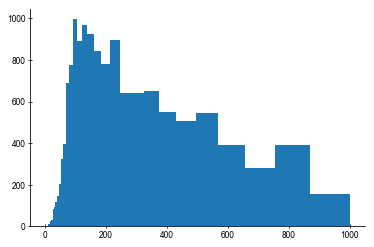

In [3]:
lens = []
for h, seq in fasta_iter(datadir+'human-viruses-uniref90_nohiv.fasta'):
    lens.append(len(seq))
n = len(lens)
plt.hist(lens, bins=np.logspace(0, 3));
n

# kmer distribution

In [4]:
counters = [count_kmers_proteome(human, k, clean=True) for k in range(1, 10)]

1.151827e+07, 6.400000e+07


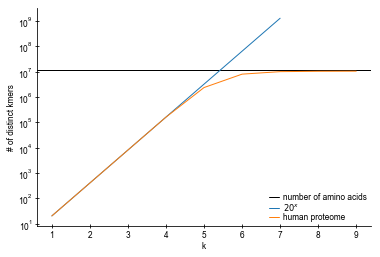

In [5]:
totalpeptides = np.sum(list(counters[0].values()))
print('%e, %e'%(totalpeptides, 20**6))
fig = plt.figure()
x = np.arange(1, 8)
plt.axhline(totalpeptides, color='k', label='number of amino acids')
plt.plot(x, 20**x, label='$20^x$')
plt.plot(range(1, len(counters)+1), [len(c) for c in counters], label='human proteome')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('# of distinct kmers')
plt.legend(loc='lower right')
fig.savefig(plotsdir + 'kmerscaling.png', dpi=300)

1.151827e+07, 6.400000e+07


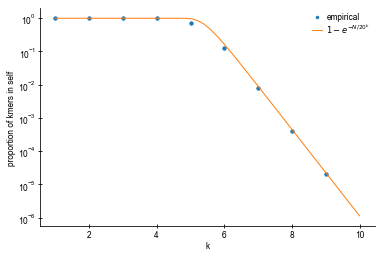

In [6]:
totalpeptides = np.sum(list(counters[0].values()))
print('%e, %e'%(totalpeptides, 20**6))
fig = plt.figure()
ks = np.arange(1, len(counters)+1)
plt.plot(ks, np.array([len(c) for c in counters])/20**ks, 'o', label='empirical')
ks = np.linspace(1, len(counters)+1)
N = totalpeptides
plt.plot(ks, 1-np.exp(-N/20**ks), label='$1-e^{-N/20^k}$')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('proportion of kmers in self')
plt.legend(loc='upper right')
fig.savefig(plotsdir+'kmerpercentagescaling.png', dpi=300)

In [7]:
df1 = counter_to_df(count_kmers_proteome(human, k=1))
df1.set_index('seq', inplace=True)

4.321928094887363 [4.16109846 4.1447261  4.10376205 3.82228886 2.1972697  0.48068123
 0.08403958]


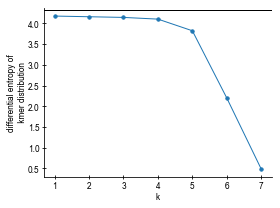

In [8]:
entropies = np.array([entropy(normalize(c), base=2) for i, c in enumerate(counters[:-1])])
print(np.log2(20), np.diff(entropies))
fig = plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, len(counters))[:-1], np.append([entropies[0]], np.diff(entropies))[:-1], 'o-')
#plt.ylim(4.0, 4.35)
plt.axhline(np.log2(20), c='k')
plt.xlabel('k')
plt.ylabel('differential entropy of\n kmer distribution');
fig.tight_layout()
fig.savefig(plotsdir+'diffentropy.png', dpi=300)

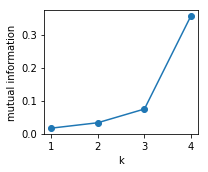

In [7]:
fig = plt.figure(figsize=(3, 2.5))
plt.plot(np.arange(1, len(counters)-1)[:-1], (entropies[0]-np.diff(entropies))[:-1], 'o-')
#plt.ylim(4.0, 4.35)
#plt.axhline(np.log2(20), c='k')
#plt.yscale('log')
plt.xlabel('k')
plt.ylabel('mutual information');
fig.tight_layout()
fig.savefig(plotsdir+'kmermutualinformation.png', dpi=300)

In [8]:
gap = 1
df2 = counter_to_df(count_kmers_proteome(human, k=2, gap=gap), norm=False)
df2 = df2[~df2['seq'].str.contains('U|B|X|Z')]

In [9]:
df2 = counter_to_df(count_kmers_iterable(scrambled(fasta_iter(human, returnheader=False)), k=2, gap=0), norm=False)

In [10]:
df = strcolumn_to_charcolumns(df2, 'seq')
entropy_grassberger(df.groupby('aa1').agg(np.sum)['count'], base=2) + entropy_grassberger(df.groupby('aa2').agg(np.sum)['count'], base=2) - entropy_grassberger(df2['count'], base=2)

0.0012582486762120482

# lognormal distribution of word frequencies

In [11]:
df = counter_to_df(counters[0], norm=True)
df = df[~df['seq'].str.contains('U|B|X|Z')]
mu = np.mean(np.log10(df['freq']))
sigmasq = np.var(np.log10(df['freq']))
mu, sigmasq**.5

(-1.3511648883501115, 0.22305964328982522)

In [12]:
k = 9
k*mu, (k*sigmasq)**.5

(-12.160483995151004, 0.6691789298694757)

In [13]:
(1-10**(k*mu-2*(k*sigmasq)**.5))**(k*19*totalpeptides), (1-10**(k*mu-2*(k*sigmasq)**.5))**(totalpeptides*k*(k-1)*19*20)

(0.9999382624140302, 0.9901703116396322)

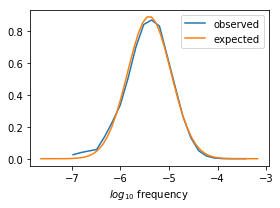

In [14]:
k = 4
df = counter_to_df(counters[k-1], norm=True)
df = df[~df['seq'].str.contains('U|B|X|Z')]
fig, ax = plt.subplots(figsize=(4, 3))
counts, bins = np.histogram(np.log10(df['freq']), bins=int(2*np.log(len(df['freq']))))
ax.plot(0.5*(bins[:-1]+bins[1:]), counts/(np.sum(counts)*np.diff(bins)), label='observed')
x = np.linspace(k*mu-5*(k*sigmasq)**.5, k*mu+5*(k*sigmasq)**.5)
plt.plot(x, scipy.stats.norm.pdf(x, k*mu, (k*sigmasq)**.5), label='expected')
plt.xlabel('$log_{10}$ frequency');
#plt.yscale('log')
plt.legend()
fig.tight_layout()
fig.savefig(plotsdir+'lognormal-wordfrequency-4mer.png', dpi=300)

# Comparison of human and pathogen proteome

In [15]:
df = counter_to_df(count_kmers_proteome(human, 1), norm=True)
df2 = counter_to_df(count_kmers_proteome(malaria, 1), norm=True)
dfmerged = pd.merge(df, df2, on='seq', suffixes=['_human', '_pathogen'])
dfmerged.to_csv('data.csv')

In [16]:
entropy(dfmerged['freq_human'], dfmerged['freq_pathogen']), entropy(dfmerged['freq_pathogen'], dfmerged['freq_human'])

(0.23047185251818594, 0.2437494534747301)

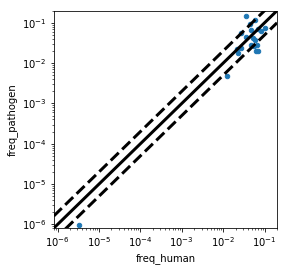

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax = 0.25*np.amin(dfmerged['freq_human']), 2*np.amax(dfmerged['freq_human'])
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
dfmerged.plot(x='freq_human', y='freq_pathogen', kind='scatter', logx=True, logy=True, ax=ax);

In [18]:
dfmerged['freq_human'].min()

3.253951286238574e-06

In [19]:
dfmerged['fold'] = dfmerged['freq_pathogen']/dfmerged['freq_human']
dfmerged.sort_values('fold', ascending=False)

,seq,freq_human,freq_pathogen,fold
15,N,0.035851,1.441038e-01,4.019472
17,I,0.043349,9.262248e-02,2.136671
3,Y,0.026659,5.692200e-02,2.135160
7,K,0.057261,1.174900e-01,2.051829
5,D,0.047393,6.471228e-02,1.365442
14,F,0.036480,4.373417e-02,1.198852
0,M,0.021320,2.191991e-02,1.028135
6,E,0.071046,7.155117e-02,1.007113
16,H,0.026240,2.410850e-02,0.918768
18,C,0.022973,1.762802e-02,0.767325


# doublet enrichment

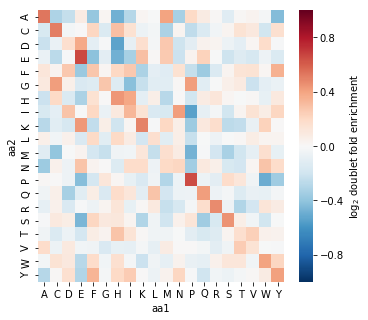

In [20]:
df1, df2 = counter_to_df(counters[0]), counter_to_df(counters[1])
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U|B|X|Z')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']
plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-1.0, vmax=1.0, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))

0.6564263425599639 0.04638286085156765 0.0014057854006050974


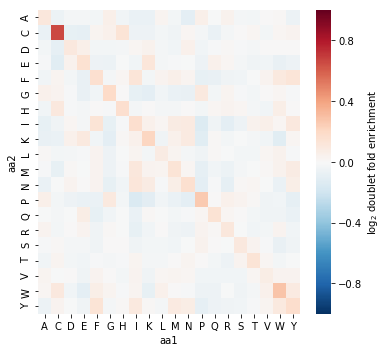

In [21]:
df1, df2 = counter_to_df(counters[0]), counter_to_df(count_kmers_iterable(scrambled(fasta_iter(human, returnheader=False)), k=2, gap=0))
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]) for s in df2['seq']]
df2['fold'] = np.log2(df2['freq']/df2['theory'])
print(np.abs(df2['fold']).max(), np.abs(df2['fold']).mean(), 2*entropies[0]-entropy(df2['freq'], base=2))
dfmat = df2.pivot(columns='aa1', index='aa2')['fold']
fig = plt.figure(figsize=(5.5, 5))
sns.heatmap(dfmat, vmin=-1.0, vmax=1.0, cmap='RdBu_r', cbar_kws=dict(label='log$_2$ doublet fold enrichment'))
fig.tight_layout()
fig.savefig(plotsdir+'doublet-shuffled.png', dpi=300)

In [22]:
df1, df2 = counter_to_df(counters[0], norm=True), counter_to_df(count_kmers_proteome(human, k=2, gap=20), norm=False)
df1.set_index('seq', inplace=True)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
df2['theory'] = [float(df1.loc[s[0]] * df1.loc[s[1]]*df2['count'].sum()) for s in df2['seq']]
pivot = df2.pivot(columns='aa1', index='aa2')

Text(0.5, 0, 'expected counts')

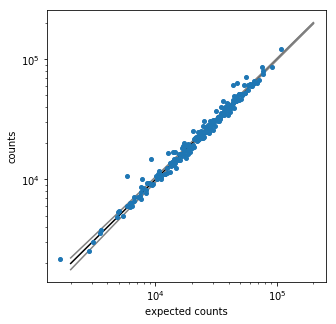

In [23]:
mask = np.tri(*pivot['count'].shape, k=-1)
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(pivot['theory'], mask=mask)
arrT = np.ma.array(pivot['count'], mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts')
plt.xlabel('expected counts')

# Mirror sequence analysis

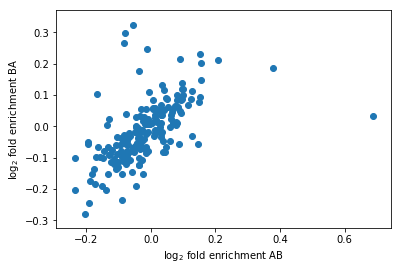

In [24]:
mask = np.tri(*pivot['count'].shape, k=0)
enrichment = np.log2(pivot['count']/pivot['theory'])
plt.scatter(np.ma.array(enrichment, mask=mask),
            np.ma.array(enrichment.T, mask=mask))
plt.xlabel('log$_2$ fold enrichment AB')
plt.ylabel('log$_2$ fold enrichment BA');

In [25]:
df2 = counter_to_df(counters[1], norm=False)
df2 = df2[~df2['seq'].str.contains('U')]
strcolumn_to_charcolumns(df2, 'seq')
counts = df2.pivot(columns='aa1', index='aa2')['count']

Text(0.5, 0, 'counts of AB')

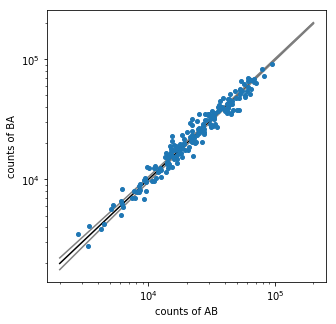

In [26]:
plt.figure(figsize=(5, 5))
x = np.linspace(2e3, 2e5)
plt.plot(x, x, 'k')
plt.plot(x, x+5*x**.5, 'gray')
plt.plot(x, x-5*x**.5, 'gray')
arr = np.ma.array(counts, mask=mask)
arrT = np.ma.array(counts.T, mask=mask)
plt.plot(arr.flatten(), arrT.flatten(), 'o', ms=4)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('counts of BA')
plt.xlabel('counts of AB')

Text(28.5, 0.5, 'amino acid 2')

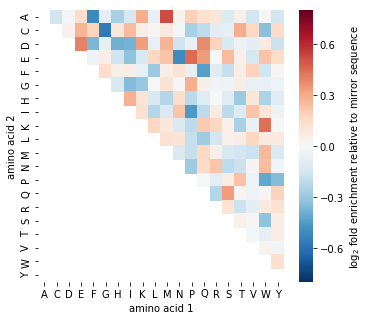

In [27]:
plt.figure(figsize=(5.5, 5))
fold = np.log2(counts/counts.T)
sns.heatmap(fold, mask=mask, vmin=-0.8, vmax=0.8, cmap='RdBu_r',
            cbar_kws=dict(label='log$_2$ fold enrichment relative to mirror sequence'))
plt.xlabel('amino acid 1')
plt.ylabel('amino acid 2')

# amino acid frequencies across different proteins

In [28]:
aas = unique_amino_acids(fasta_iter(human))

In [29]:
def aa_frequencies(proteome, min_length=1):
    n = sum([1 for h, seq in fasta_iter(proteome) if len(seq)>=min_length])
    array = np.zeros((n, len(aas)))
    i = 0
    for h, seq in fasta_iter(proteome):
        seq = seq.replace('X', '')
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        sum_ = np.sum(list(counter.values()))
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]/sum_
        i += 1
    return array

In [30]:
min_length = 10
aa_human = aa_frequencies(human, min_length=min_length)
aa_malaria = aa_frequencies(malaria, min_length=min_length)
aa_influenzaB = aa_frequencies(influenzaB, min_length=min_length)
aa_cmv = aa_frequencies(cmv, min_length=min_length)
aa_listeria = aa_frequencies(listeria, min_length=min_length)
aa_hiv = aa_frequencies(hiv, min_length=min_length)

(-0.3, 0.3)

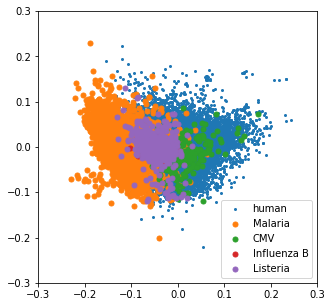

In [31]:
fig = plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pcad_human = pca.fit_transform(aa_human)
plt.scatter(pcad_human[:, 0], pcad_human[:, 1], s=4, label='human')
for label, aa in [('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB),  ('Listeria', aa_listeria)]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.3
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

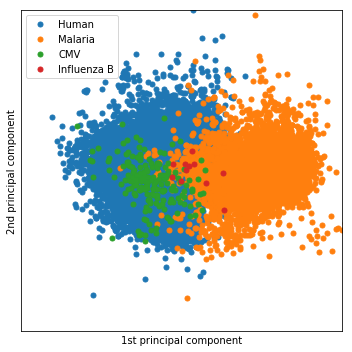

In [32]:
fig = plt.figure(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_human, aa_malaria, aa_cmv, aa_influenzaB]))
for label, aa in [('Human', aa_human), ('Malaria', aa_malaria), ('CMV', aa_cmv), ('Influenza B', aa_influenzaB)]:
    pcad_pathogen = pca.transform(aa)
    plt.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=25)
plt.legend()
lim = 0.25
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
fig.tight_layout()
fig.savefig(plotsdir+'pcaanalysis.png')

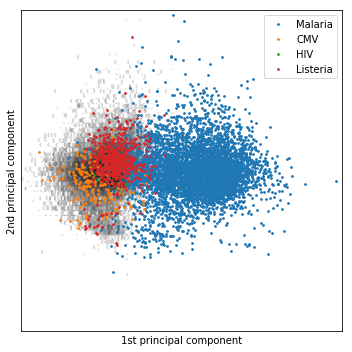

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
pca = sklearn.decomposition.PCA(n_components=2)
pca = pca.fit(np.vstack([aa_listeria, aa_malaria, aa_cmv, aa_hiv]))
pcad = pca.transform(aa_human)
ax.hexbin(pcad[:, 0], pcad[:, 1], bins='log', cmap='gray_r')
for label, aa in [('Malaria', aa_malaria), ('CMV', aa_cmv),
                  ('HIV', aa_hiv),
                  #('Influenza B', aa_influenzaB),
                  ('Listeria', aa_listeria)]:
    pcad_pathogen = pca.transform(aa)
    ax.scatter(pcad_pathogen[:, 0], pcad_pathogen[:, 1], label=label, s=3)
plt.legend()
lim = 0.25
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xticks([])
plt.yticks([])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
fig.tight_layout()
fig.savefig(plotsdir+'pcaanalysis.png', dpi=300)

In [34]:
trans = sklearn.manifold.MDS(n_components=2)
aafreqs = [aa_human[:1000, :], aa_malaria, aa_cmv, aa_influenzaB]
transd = trans.fit_transform(np.vstack(aafreqs))

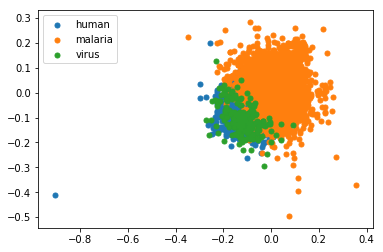

In [35]:
len_aafreqs = [aa.shape[0] for aa in aafreqs]
plt.scatter(transd[:len_aafreqs[0], 0], transd[:len_aafreqs[0], 1], label='human', s=25)
plt.scatter(transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 0], transd[len_aafreqs[0]:len_aafreqs[0]+aa_malaria.shape[0], 1], label='malaria', s=25)
plt.scatter(transd[len_aafreqs[0]+aa_malaria.shape[0]:, 0], transd[len_aafreqs[0]+aa_malaria.shape[0]:, 1], label='virus', s=25)
plt.legend()

In [36]:
dfcmv = pd.read_csv('/home/amayer/data/proteomes/cmv-iedb-epitopes.csv', header=1, usecols=(2, 9))
dfcmv['length'] = [len(d) for d in dfcmv['Description']]

FileNotFoundError: File b'/home/amayer/data/proteomes/cmv-iedb-epitopes.csv' does not exist

In [ ]:
def aa_frequencies_list(list_, min_length=1):
    array = np.zeros((len(list_), len(aas)))
    i = 0
    for seq in list_:
        seq = ''.join( c for c in seq if c in list(aas))
        if len(seq) < min_length:
            continue
        counter = {}
        for aa in aas:
            counter[aa] = 0
        count_kmers(seq, 1, counter=counter)
        for j, aa in enumerate(aas):
            array[i, j] = counter[aa]
        i += 1
    return array

In [ ]:
aa_cmv_epitopes = aa_frequencies_list(list(dfcmv[(dfcmv['length']<25)&(dfcmv['length']>5)]['Description']))
aa_cmv_epitope = aa_cmv_epitopes.sum(axis=0)
aa_cmv_epitope /= np.sum(aa_cmv_epitope)

aah = aa_human.sum(axis=0)
aah /= np.sum(aah)

aac = aa_cmv.sum(axis=0)
aac /= np.sum(aac)

In [ ]:
df = pd.DataFrame(dict(freq=np.concatenate([aah, aac, aa_cmv_epitope]),
                       aas=np.concatenate([aas]*3),
                       provenance=np.concatenate([['human']*len(aas), ['cmv']*len(aas), ['cmv_epitope']*len(aas)])))
df.head()

In [ ]:
df = pd.DataFrame(dict(human=aah, cmv=aac, cmv_epitope=aa_cmv_epitope, aas=aas))
df.plot.bar(x='aas')

# Probability given independent model

In [ ]:
df0 = counter_to_df(counters[0])
df0 = df0.set_index('seq')
humanaaprobdict = np.log10(df0['freq']).to_dict()
humanaaprobdict

In [ ]:
dfepitope = pd.read_csv('/home/amayer/data/proteomes/allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitope = dfepitope.fillna('')
counts = dfepitope.groupby('Parent Organism')['Description'].count()
counts.to_csv('organisms.csv')
counts[counts>300].sort_values()

correspondence:
Human gammaherpesvirus 4 = Epstein Barr virus (EBV)

In [ ]:
dfepitope = pd.read_csv('/home/amayer/data/proteomes/allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
dfepitope = dfepitope.fillna('')
dfepitope = dfepitope[dfepitope['Parent Organism'].str.contains('Influenza B')]
dfepitope['length'] = [len(d) for d in dfepitope['Description']]
dfepitope['length'].hist(bins=np.arange(50))
plt.xlim(0, 50);

In [ ]:
k = 9
#epi = list(dfepitope[dfepitope['length']==k]['Description'])
epi = list(dfepitope['Description'])
pepitope = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for seq in epi for i in range(len(seq)-k+1) ])
pepitope = pepitope[~np.isnan(pepitope)]
phuman = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])
ppathogen = np.array([loglikelihood_independent(seq[i:i+k], humanaaprobdict, k) for h, seq in fasta_iter(pseudoburk) for i in range(len(seq)-k+1) ])

In [ ]:
plot_histograms([phuman, ppathogen, pepitope], ['human', 'pathogen', 'epitope'])

In [ ]:
np.mean(phuman), np.mean(ppathogen), np.mean(pepitope)

In [ ]:
df5 = counter_to_df(counters[5], norm=False)

In [ ]:
#loglikelihood = lambda seq: loglikelihood_triplet(seq, humanaaprobdict, humandoubletprobdict, humantripletprobdict)
loglikelihood = lambda seq: loglikelihood_independent(seq, humanaaprobdict)
df5['theory'] = df5['count'].sum() * np.array([10**loglikelihood(seq) for seq in df5['seq'] ])

In [ ]:
plt.figure(figsize=(5, 5))
x = np.linspace(1e-2, 1e4)
plt.plot(x, x, 'k')
#plt.plot(x, x+5*x**.5, 'gray')
#plt.plot(x, x-5*x**.5, 'gray')
plt.plot(df5['theory'], df5['count'], 'o', ms=2)
#plt.plot(x, 1.3*x, 'g')
#plt.plot(x, x/1.3, 'g')
plt.xlim(1e-3, 1e4)
plt.ylim(1e-3, 1e4)
plt.xscale('log')
plt.yscale('log')

# Probability given markov chain model

In [ ]:
df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log10(count).to_dict()

In [ ]:
epi = list(dfepitope['Description'])
pepitope_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in epi for i in range(len(seq)-k+1)])
pepitope_mc = pepitope_mc[~np.isnan(pepitope_mc)]
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
ppathogen_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(ebv) for i in range(len(seq)-k+1)])

In [ ]:
plot_histograms([phuman_mc, ppathogen_mc, pepitope_mc], ['human', 'pathogen', 'epitope'])

In [ ]:
x = np.linspace(-22, -16)
plt.plot(x, x, 'k', lw=2)
plt.scatter(phuman[:1000], phuman_mc[:1000])

In [ ]:
j = sns.jointplot(x=phuman[:1000], y=phuman_mc[:1000], kind="hex",
                 joint_kws=dict(gridsize=20));
j.ax_joint.plot(x, x, 'k', lw=2)

In [ ]:
np.mean(phuman), np.mean(phuman_mc)

In [ ]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log10(count).to_dict()

In [ ]:
epi = list(dfepitope['Description'])
pepitope_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for seq in epi for i in range(len(seq)-k+1)])
pepitope_tri = pepitope_tri[~np.isnan(pepitope_tri)]
phuman_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
ppathogen_tri = np.array([loglikelihood_triplet(seq[i:i+k], humanaaprobdict, humandoubletprobdict, humantripletprobdict, k) for h, seq in fasta_iter(ebv) for i in range(len(seq)-k+1)])

In [ ]:
plot_histograms([phuman_tri, ppathogen_tri, pepitope_tri], ['human', 'pathogen', 'epitope'], nbins=60)

In [ ]:
np.mean(pepitope)-np.mean(phuman), np.mean(pepitope)-np.mean(ppathogen)

In [ ]:
np.mean(pepitope_mc)-np.mean(phuman_mc), np.mean(pepitope_mc)-np.mean(ppathogen_mc), 

In [ ]:
np.mean(pepitope_tri)-np.mean(phuman_tri), np.mean(pepitope_tri)-np.mean(ppathogen_tri), 

# Using protein abundance information

In [ ]:
paxdb = pd.read_csv('/home/amayer/data/proteomes/paxdb/9606-WHOLE_ORGANISM-integrated.txt', delimiter='\t', header=11)
paxdb['string_external_id'] = [s[5:] for s in paxdb['string_external_id']]
paxdb.head()

In [ ]:
uniprot_to_paxdb = pd.read_csv('/home/amayer/data/proteomes/paxdb/full_uniprot_2_paxdb.04.2015.tsv', delimiter='\t')
uniprot_to_paxdb['uniprot'] = [s.split('|')[0] for s in uniprot_to_paxdb['uniprot']]
uniprot_to_paxdb = uniprot_to_paxdb[uniprot_to_paxdb['organism']==9606]
uniprot_to_paxdb.head()

In [ ]:
hs, seqs = list(zip(*((h.split('|')[1], seq) for h, seq in fasta_iter(human))))
dfuniprot = pd.DataFrame(dict(name=hs, sequence=seqs))
dfuniprot.head()

In [ ]:
merged = paxdb.merge(uniprot_to_paxdb, left_on='string_external_id', right_on='ENSP')
dfuniprot = dfuniprot.merge(merged, left_on='name', right_on='uniprot')
dfuniprot = dfuniprot.filter(items=['name', 'sequence', 'abundance'])

In [ ]:
seqs = dfuniprot[dfuniprot['abundance']<0.01]['sequence']
len(seqs)

In [ ]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

In [ ]:
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'abundant human'])

# Distribution of mitochondrial genes

In [ ]:
df_mitocarta = pd.read_csv('/home/amayer/Dropbox/mtantigens/data/human-mitocarta.csv', sep='\t', usecols=(0, 4))

In [ ]:
df_mitocarta['uniprot'] = [s[-6:] for s in df_mitocarta['Synonyms']]
df_mitocarta.head()

In [ ]:
dfuniprot = dfuniprot.merge(df_mitocarta, left_on='name', right_on='uniprot')

In [ ]:
seqs = dfuniprot[dfuniprot['TrainingDataset'] == 'Tmito']['sequence']
len(seqs)

In [ ]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

In [ ]:
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'mitochondria-associated'])

In [ ]:
hs, seqs = list(zip(*((h.split('|')[1], seq) for h, seq in fasta_iter(human) if 'GN=MT-' in h)))
dfmt = pd.DataFrame(dict(name=hs, sequence=seqs))
seqs = dfmt['sequence']
len(seqs)

In [ ]:
k = 9
phuman_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1)])
pabundant_mc = np.array([loglikelihood_mc(seq[i:i+k], humanaaprobdict, humandoubletprobdict, k) for seq in seqs for i in range(len(seq)-k+1)])

In [ ]:
fig, ax = plt.subplots()
plot_histograms([phuman_mc, pabundant_mc], ['all human', 'mitochondrial'])
ax.set_ylabel('frequency')
ax.set_xlabel('probability given human proteome statistics')
fig.tight_layout()
fig.savefig(plotsdir+'likelihoodprofile-mitochondria.png', dpi=300)

In [ ]:
np.mean(phuman_mc), np.mean(pabundant_mc)